######Fine Tuning models output only generic names. In "Fine-tuning sentiment analysis" notebook the issue was solved kind of hacky way which was to modify the config file after calling save method. Luckily, there is a slightly better way. It would be nice if we could pass in specific label names but unfortunately currently it's not possible. However, there is a way to achieve a similar effect. In particular, hugging face also has config objects. We can pass in this config object into the from_pre_trained method. So, it pretty much works like our ideal scenario.

⚒ Note: These config objects are model specific like tokenizers. So there is bert config, GPT2 config and so forth. Also there is an auto config which automatically chooses the right config object based on the checkpoint we give it. In summary, just like we have auto tokenizers, auto models we can have auto configs.

In [ ]:
! pip install -U accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.4 MB/s eta 0:00:00


In [ ]:
! pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 26.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


In [ ]:
!pip show accelerate


Name: accelerate
Version: 0.25.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: sylvain@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [ ]:
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split


In [ ]:
df_ = pd.read_csv("/content/drive/MyDrive/Datasets /Tweets.csv")

In [ ]:
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df = df_[['airline_sentiment', 'text']].copy()

In [ ]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<Axes: >

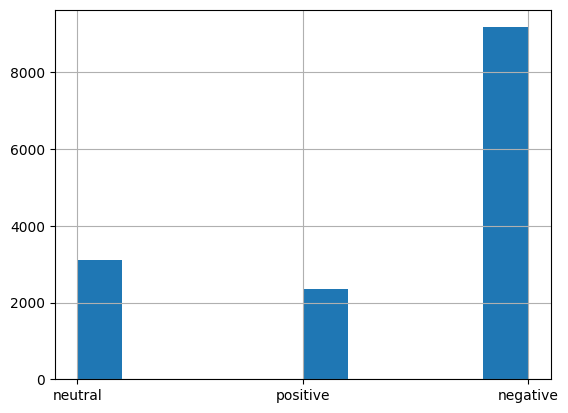

In [ ]:
df['airline_sentiment'].hist()

In [ ]:
target_map = {'positive': 1, 'negative': 0, 'neutral': 2}
df['target'] = df['airline_sentiment'].map(target_map)

In [ ]:
df2 = df[['text', 'target']]
df2.columns = ['sentence', 'label']  # to use fine tune the transformer target column must be renamed as label
df2.to_csv('data.csv', index=None)

In [ ]:
!head data.csv

sentence,label
@VirginAmerica What @dhepburn said.,2
@VirginAmerica plus you've added commercials to the experience... tacky.,1
@VirginAmerica I didn't today... Must mean I need to take another trip!,2
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",2


In [ ]:
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files='data.csv')

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
# Note that in the datasetDict it only contains train because we haven't split it away
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [ ]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)

In [ ]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [ ]:
# if you have multiple csv files
# load_dataset('csv', data_files=['file1.csv', 'file2.csv'])

In [ ]:
# if you already have a train-test split:
# load_dataset(
#     'csv',
#     data_files={'train': ['train.csv', 'train2.csv'],
#                 'test': 'test.csv'
#                 }
# )

In [ ]:
checkpoint = 'distilbert-base-cased'

In [ ]:
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation=True)


In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, AutoConfig, TrainingArguments

In [ ]:
tokenized_datasets = split.map(tokenize_fn, batched=True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

In [ ]:
# difference from previous notebook starts here
config = AutoConfig.from_pretrained(checkpoint)

In [ ]:
config  # Notice: There's nothing here about label names

DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.36.2",
  "vocab_size": 28996
}

In [ ]:
config.id2label

{1: 'positive', 0: 'negative', 2: 'neutral'}

In [ ]:
config.label2id

{'positive': 1, 'negative': 0, 'neutral': 2}

In [ ]:
config.id2label = {v:k for k, v in target_map.items()}
config.label2id = target_map

In [ ]:
config.label2id

{'positive': 1, 'negative': 0, 'neutral': 2}

In [ ]:
# Now we need to pass in the config inside the Automodel
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, config=config
)

# the rest of the code is similar to the previous notebook

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

In [ ]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [ ]:
training_args = TrainingArguments(
    output_dir = 'training_dir',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    num_train_epochs = 3,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 64,
)

In [ ]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average='macro')
  return {'accuracy': acc, 'f1': f1}

In [ ]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.546900,0.466407,0.826275,0.761705
2,0.344100,0.489625,0.834927,0.771903
3,0.245300,0.644340,0.829918,0.778731


TrainOutput(global_step=1923, training_loss=0.3293969228251552, metrics={'train_runtime': 203.9049, 'train_samples_per_second': 150.776, 'train_steps_per_second': 9.431, 'total_flos': 388879472366064.0, 'train_loss': 0.3293969228251552, 'epoch': 3.0})

In [ ]:
# Notice: our models seem to over fit a bit on the third epoch.
# However, this doesn't mean that we have to start all over again.
# Since the model was saved at the end of each epoch, we can simply take the best model from one of the intermidiate steps


In [ ]:
!ls training_dir

checkpoint-1282  checkpoint-1923  checkpoint-641  runs


In [ ]:
from transformers import pipeline

In [ ]:
saved_model = pipeline('text-classification',
                       model='training_dir/checkpoint-1282',
                       device=0)

In [ ]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4392
})

In [ ]:
test_pred = saved_model(split['test']['sentence'])

In [ ]:
test_pred[:3]

[{'label': 'positive', 'score': 0.9210001230239868},
 {'label': 'positive', 'score': 0.9570583701133728},
 {'label': 'positive', 'score': 0.6236855983734131}]

In [ ]:
def get_label(d):
    # Use config.label2id to map label names to their corresponding numeric values
    label_name = d['label']
    if label_name in config.label2id:
        return config.label2id[label_name]
    else:
        # Handle the case where the label is not in the dictionary
        raise ValueError(f"Label '{label_name}' not found in label2id dictionary")

In [ ]:
test_pred = [get_label(d) for d in test_pred]

In [ ]:
test_pred[:3]

[1, 1, 1]

In [ ]:
print("accuracy: ", accuracy_score(split['test']['label'], test_pred))

accuracy:  0.8349271402550091


In [ ]:
print("f1: ", f1_score(split['test']['label'], test_pred, average='macro'))

f1:  0.7719031023907544


In [ ]:
# sample data
s = split['test']['sentence'][0]
s

'@JetBlue thank you!'

In [ ]:
# loading the saved the model
saved_model(s)

[{'label': 'positive', 'score': 0.9210001230239868}]